<a href="https://colab.research.google.com/github/pikachom/pytorch/blob/master/BERT_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 27.1MB/s 
     |████████████████████████████████| 655kB 41.9MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609238 sha256=0c6f6809343318a272de0b8569ea5862790d6d445cc2c0919bf45ecf1d036a11
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange #progress bar library
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla K80'

In [7]:
from google.colab import files
uploaded = files.upload()


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [9]:
df.shape

(8551, 4)

In [13]:
df.sample(10)

,sentence_source,label,label_notes,sentence
6693,m_02,1,NaN,Mr Woodhouse sat in an armchair.
3394,l-93,1,NaN,They waltzed.
2435,l-93,1,NaN,It was believed that the earth was round.
6590,g_81,1,NaN,People are said to do crazier things at higher...
741,bc01,0,*,He impresses his friends all as pompous.
5887,c_13,1,NaN,George gave Jessica the book.
179,cj99,0,*,"I don't plan to lock the door, no matter how f..."
385,bc01,1,NaN,The question of whether John met Mary worries ...
5830,c_13,1,NaN,Bill wants Susan to leave.
8378,ad03,1,NaN,The intrepid pirate and the fearful captain's ...


In [0]:
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 423869.99B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [0]:
'''
<input format of BERT>
input ids : sequence of integers identifying eath input token to its index number in BERT tokenizer vocab
segment mask(optional) : (sequence) 1 sentence -> 0 mask, 2 sentence -> 1 mask for SOS of each sentence & 0 mask for other
attention mask : (sequence) 1 mask for all input tokens, 0 mask for all padding tokens
labels : (single value) 1 mask for grammatical, 0 mask for ungrammatical
<what is padding token?>
for same input array size, padding tokens are needed
'''
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [0]:
attention_masks = []

#create attention mask
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
#use train_test_split to split my data
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state = 2018,
                                                                                    test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state = 2018,
                                                       test_size = 0.1)


In [21]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [0]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [24]:
'''
base : smaller version( vs large)
uncased : only lowercase version
'''
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:37<00:00, 10927734.78B/s]


In [0]:
'''
BERT recommended hyper-parameter
Batch size : 16, 32
lr(Adam) : 5e-5, 3e-5, 2e-5
# epochs : 2,3,4
'''
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}
]

In [26]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
'''
<training loop>
1. tell the model to compute gradients by setting the model in train mode
2. unpack our data inputs and labels
3. load data onto the GPU for acceleration
4. clear out the gradients calculated in the previous pass
***in pytorch, gradients accumulate by default
5. forward
6. backward
7. tell the network to update parameters(optimizer.step())
8. track variables for monitoring progress

<evaluation loop>
1. tell the model not to compute gradients by setting the model in evaluation mode
2. unpack our data inputs and labels
3. load data onto the GPU for acceleration
4. forward
5. compute loss on our validation data and track variables for monitoring progress

'''
#prediction vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
train_loss_set = []
epochs = 4
model.to(device)
for _ in trange(epochs, desc="Epoch"):
  model.train()
  #tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  #train the data(one epoch)
  for step, batch in enumerate(train_dataloader):
    #add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    #unpack input from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients (not to accumulate with pytorch default)
    optimizer.zero_grad()
    #forward
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    #backward
    loss.backward()
    #update params
    optimizer.step()


    #update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  #validation
  #put model to evaluation mode
  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    # logit is model output
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


  

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

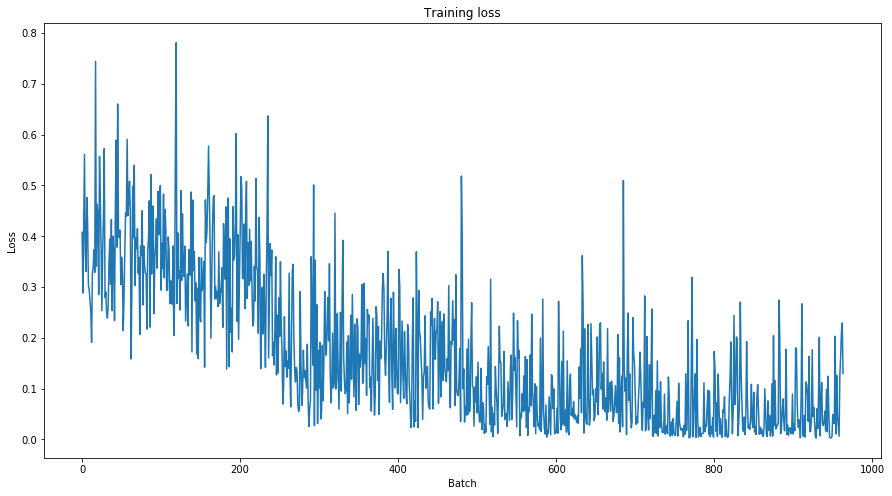

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
# Upload the test file from your local drive
# upload out of domain_dev
from google.colab import files
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5081700925544508

In [32]:
flat_true_labels

NameError: ignored